In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
HIDDEN_LAYER = 256  # NN hidden layer size

class DQN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [12]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            state=Variable(state, volatile=True).type(FloatTensor)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        print('rnd')
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    #if is_ipython:
    #    display.clear_output(wait=True)
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        #display.clear_output(wait=True)
        display.display(plt.gcf())

In [13]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [14]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
0 cur_step: 20
reward: 1.0
reward: 1.0
reward: 1.0
rnd
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
1 cur_step: 10
reward: 1.0
rnd
reward: 1.0
rnd
reward: 1.0
rnd
reward: 1.0
rnd
reward: 1.0
rnd
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
rnd
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
rnd
reward: 1.0
rnd
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
reward: 1.0
rnd
reward: 1.0
reward: 1.0
reward: 1.0
2 cur_step: 42
rnd
reward: 1.0
rnd
reward: 1.0
reward: 1.0
reward:

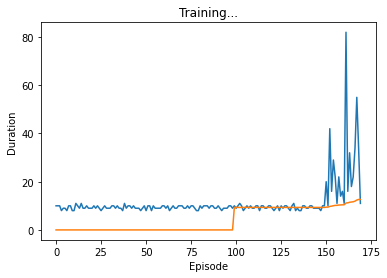

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
num_episodes = 20
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    cur_step=0
    for t in count():
        # Select and perform an action
        action = select_action(FloatTensor([state]))
        next_state, reward, done, _ = env.step(action.item())
        print(f'reward: {reward}')
        reward = torch.tensor([reward], device=device)
        if done:
            memory.push(FloatTensor([state]), action, None, FloatTensor([reward]))
        else:
            memory.push(FloatTensor([state]), action, FloatTensor([next_state]), FloatTensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        cur_step+=1
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            print(f'{i_episode} cur_step: {cur_step}')
            break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if t>500:
        break
print('Complete')
plot_durations()
#env.render()
plt.ioff()
plt.show()

0 cur_step: 1
0 cur_step: 2
0 cur_step: 3
0 cur_step: 4
0 cur_step: 5
0 cur_step: 6
0 cur_step: 7
0 cur_step: 8
0 cur_step: 9
0 cur_step: 9
0
1 cur_step: 1
1 cur_step: 2
1 cur_step: 3
1 cur_step: 4
1 cur_step: 5
1 cur_step: 6
1 cur_step: 7
1 cur_step: 8
1 cur_step: 9
1 cur_step: 10
1 cur_step: 11
1 cur_step: 12
1 cur_step: 12
1
2 cur_step: 1
2 cur_step: 2
2 cur_step: 3
2 cur_step: 4
2 cur_step: 5
2 cur_step: 6
2 cur_step: 7
2 cur_step: 8
2 cur_step: 9
2 cur_step: 10
2 cur_step: 11
2 cur_step: 12
2 cur_step: 13
2 cur_step: 14
2 cur_step: 15
2 cur_step: 16
2 cur_step: 17
2 cur_step: 18
2 cur_step: 19
2 cur_step: 20
2 cur_step: 21
2 cur_step: 22
2 cur_step: 23
2 cur_step: 24
2 cur_step: 25
2 cur_step: 26
2 cur_step: 27
2 cur_step: 28
2 cur_step: 29
2 cur_step: 30
2 cur_step: 31
2 cur_step: 32
2 cur_step: 33
2 cur_step: 34
2 cur_step: 34
2
3 cur_step: 1
3 cur_step: 2
3 cur_step: 3
3 cur_step: 4
3 cur_step: 5
3 cur_step: 6
3 cur_step: 7
3 cur_step: 8
3 cur_step: 9
3 cur_step: 10
3 cur_step:

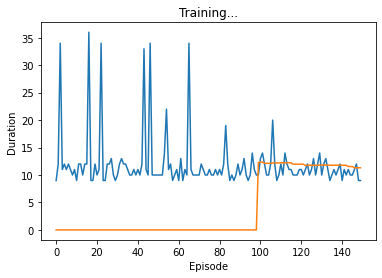

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
num_episodes = 150
episode_durations = []
for i_episode in range(num_episodes):
    state = env.reset()
    for t in count():
        action = policy_net(FloatTensor([state])).max(1)[1].view(1, 1)
        next_state, reward, done, _ = env.step(action.item())
        print(f'{i_episode} cur_step: {t+1}')  
        if done:
            episode_durations.append(t + 1)
            print(f'{i_episode} cur_step: {t+1}')
            break
        state = next_state
    print(f'{i_episode}')
plot_durations()

0 cur_step: 1
0 cur_step: 2
0 cur_step: 3
0 cur_step: 4
0 cur_step: 5
0 cur_step: 6
0 cur_step: 7
0 cur_step: 8
0 cur_step: 9
0 cur_step: 10
0 cur_step: 11
0 cur_step: 11
1 cur_step: 1
1 cur_step: 2
1 cur_step: 3
1 cur_step: 4
1 cur_step: 5
1 cur_step: 6
1 cur_step: 7
1 cur_step: 8
1 cur_step: 9
1 cur_step: 10
1 cur_step: 11
1 cur_step: 12
1 cur_step: 13
1 cur_step: 14
1 cur_step: 15
1 cur_step: 16
1 cur_step: 17
1 cur_step: 18
1 cur_step: 19
1 cur_step: 20
1 cur_step: 21
1 cur_step: 22
1 cur_step: 23
1 cur_step: 24
1 cur_step: 25
1 cur_step: 26
1 cur_step: 27
1 cur_step: 28
1 cur_step: 29
1 cur_step: 29
2 cur_step: 1
2 cur_step: 2
2 cur_step: 3
2 cur_step: 4
2 cur_step: 5
2 cur_step: 6
2 cur_step: 7
2 cur_step: 8
2 cur_step: 9
2 cur_step: 9
3 cur_step: 1
3 cur_step: 2
3 cur_step: 3
3 cur_step: 4
3 cur_step: 5
3 cur_step: 6
3 cur_step: 7
3 cur_step: 8
3 cur_step: 9
3 cur_step: 9
4 cur_step: 1
4 cur_step: 2
4 cur_step: 3
4 cur_step: 4
4 cur_step: 5
4 cur_step: 6
4 cur_step: 7
4 cur_step

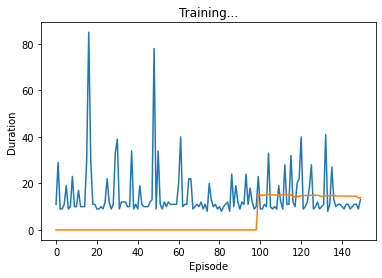

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [21]:
num_episodes = 150
episode_durations = []
for i_episode in range(num_episodes):
    state = env.reset()
    for t in count():
        # Select and perform an action
        action = target_net(FloatTensor([state])).max(1)[1].view(1, 1)
        next_state, reward, done, _ = env.step(action.item())
        print(f'{i_episode} cur_step: {t+1}')
        if done:
            episode_durations.append(t + 1)
            print(f'{i_episode} cur_step: {t+1}')
            break
        state = next_state
plot_durations()

In [22]:
env.close()